# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from PIL import Image
from numpy import asarray
from os.path import dirname, join as pjoin
import scipy.io as sio
import json
import time
import cv2
import matplotlib.cm as cm
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.transform import resize

## UCSD Dataset

UCSD dataset consists of an hour of video with 2000 annotated frames and in a total of 49,885 pedestrian
instances, which was captured from a pedestrian walkway of the UCSD campus by a stationary camera. The original video was recorded at 30fps with a frame size of 480 × 740 and later downsampled to 10fps with dimension 158×238. The 601-1400 frames were used for training and the remaining 1200 frames for testing. 
The ROI of the walkway and the traveling direction are
also provided.

It is taken from http://www.svcl.ucsd.edu/projects/peoplecnt/

### Images

In [2]:
def load_dataset(path_vidf):
    
    full_lista = []
    
    for path in os.listdir(path_vidf):
        
        lista_images=[]

        # Append images to a list
        for item in os.listdir(path_vidf+path+'/'):
            if os.path.isfile(path_vidf+path+'/'+item):
                im = Image.open(path_vidf+path+'/'+item).convert("RGB")
                im = np.array(im)
                lista_images.append(im)
        full_lista.append(np.array(lista_images))
            
    return full_lista

In [ ]:
UCSD_dataset = load_dataset('UCSDpeds/ucsdpeds/vidf/')

In [22]:
# Convert and save the list of images in '.npy' format
np.save("images_UCSD.npy",UCSD_dataset)

In [3]:
images_UCSD = np.load("images_UCSD.npy")
images_UCSD.shape

(10, 200, 158, 238, 3)

### Ground truth

In [6]:
# ground truth

gt_UCSD0 = sio.loadmat("UCSD_ground_truth/vidf1_33_000_frame_full.mat")
gt_UCSD1 = sio.loadmat("UCSD_ground_truth/vidf1_33_001_frame_full.mat")
gt_UCSD2 = sio.loadmat("UCSD_ground_truth/vidf1_33_002_frame_full.mat")
gt_UCSD3 = sio.loadmat("UCSD_ground_truth/vidf1_33_003_frame_full.mat")
gt_UCSD4 = sio.loadmat("UCSD_ground_truth/vidf1_33_004_frame_full.mat")
gt_UCSD5 = sio.loadmat("UCSD_ground_truth/vidf1_33_005_frame_full.mat")
gt_UCSD6 = sio.loadmat("UCSD_ground_truth/vidf1_33_006_frame_full.mat")
gt_UCSD7 = sio.loadmat("UCSD_ground_truth/vidf1_33_007_frame_full.mat")
gt_UCSD8 = sio.loadmat("UCSD_ground_truth/vidf1_33_008_frame_full.mat")
gt_UCSD9 = sio.loadmat("UCSD_ground_truth/vidf1_33_009_frame_full.mat")

### Labels

In [4]:
def read_mat_label(path):
    labels=[]
    for item in os.listdir(path):
        if os.path.isfile(path+item) & (item.endswith(".mat")):
            dict_label = sio.loadmat(path+item)
            labels.append(dict_label['count'])
    counts = [np.sum(labels[i], axis=1)[0] for i in range(len(labels))]  # sum of right and left counts
    return counts

In [ ]:
labels_UCSD = read_mat_label('UCSD_labels/vidf-cvpr/')

In [9]:
# Convert and save the list of images in '.npy' format
np.save("labels_UCSD.npy",labels_UCSD)

In [7]:
labels_UCSD = np.load("labels_UCSD.npy")
labels_UCSD.shape

(10, 1, 200)

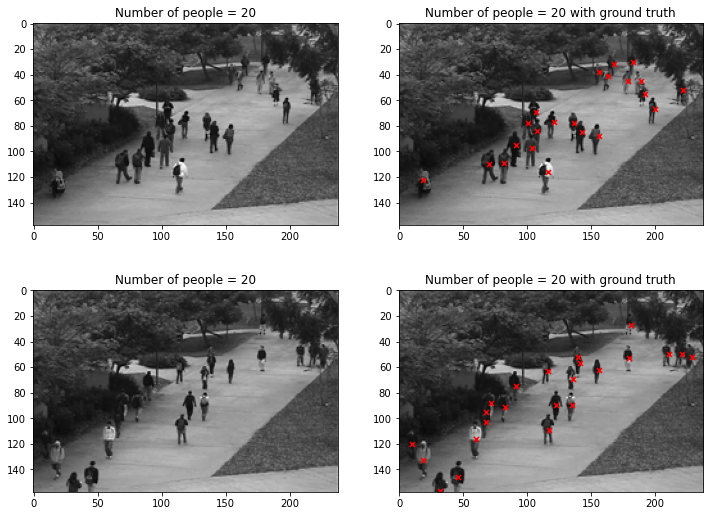

In [8]:
# lest's display 2 images with the corresponding labels and ground truth

f, ax = plt.subplots(2,2, figsize = (12, 9))

ax[0,0].imshow(images_UCSD[1][0])
ax[0,1].imshow(images_UCSD[1][0])
ax[1,0].imshow(images_UCSD[5][0])
ax[1,1].imshow(images_UCSD[5][0])

# adding ground truth
for x,y in gt_UCSD1["frame"][0,0][0,0][0][:,0:2]:
    ax[0,1].scatter(round(x),round(y), s = 25, marker = "x", color = "r")
for x,y in gt_UCSD5["frame"][0,0][0,0][0][:,0:2]:
    ax[1,1].scatter(round(x),round(y), s = 25, marker = "x", color = "r")

# titles
ax[0,0].set_title(f"Number of people = {labels_UCSD[1][0,0]}")
ax[0,1].set_title(f"Number of people = {labels_UCSD[1][0,0]} with ground truth")
ax[1,0].set_title(f"Number of people = {labels_UCSD[5][0,0]}")
_=ax[1,1].set_title(f"Number of people = {labels_UCSD[5][0,0]} with ground truth")

## Density function

In [45]:
def density_UCSD(folder, img_number, gt):

    '''
    Input:
    - folder: folder of the image
    - img_number: number of the image
    - gt: ground truth of img as dictionary

    '''

    output = np.zeros(images_UCSD[folder][img_number].shape[:-1])
    x_full = gt["frame"][0, img_number][0, 0][0][:,0]
    y_full = gt["frame"][0, img_number][0, 0][0][:,1]

    '''
    # for high number of persons
    for x, y in zip(x_full, y_full):
        density_img = np.zeros(dataset[folder][img_number].shape[:-1])
        try:
            density_img[round(y),round(x)] = 1
        except:
            pass
        nearest_distance = np.min(np.linalg.norm(x - y))
        sigma = 0.3 * nearest_distance # beta = 0.3 suggested by MCNN paper
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size,kernel_size), sigma)
        output += density_img
    '''
    
    for x, y in zip(x_full, y_full):
        density_img = np.zeros(images_UCSD[folder][img_number].shape[:-1])
        try:
            density_img[round(y),round(x)] = 1
        except:
            pass

        sigma = 3 
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size,kernel_size), sigma)
        output += density_img 

    return cv2.GaussianBlur(output, (11,11), sigma)

Time: 0.004997968673706055


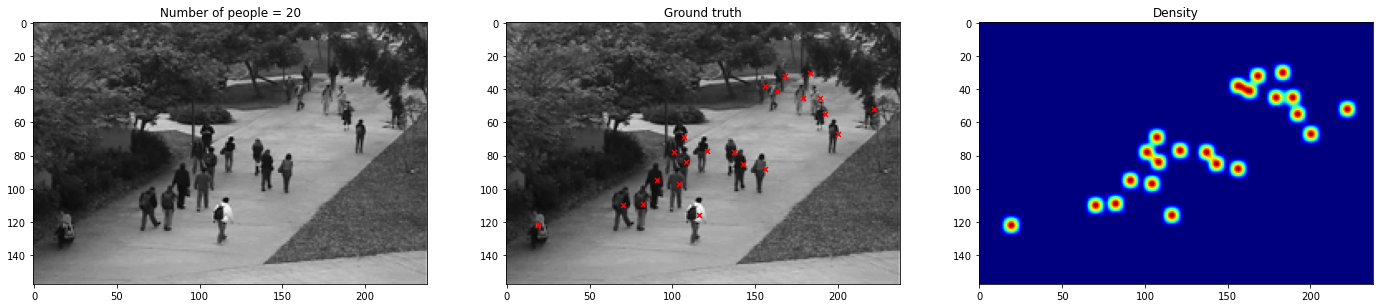

In [46]:
# density map on first image from folder 1 of UCSD dataset

start = time.time()
ds = density_UCSD(folder=1, img_number=0, gt=gt_UCSD1)
print(f"Time: {time.time() - start}")

plt.figure(figsize=(24, 9))

#image with label
plt.subplot(1, 3, 1)
plt.imshow(images_UCSD[1][0])
plt.title(f"Number of people = {labels_UCSD[1][0,0]}")

# image with ground truth
plt.subplot(1, 3, 2)
plt.imshow(images_UCSD[1][0])
for x,y in gt_UCSD1["frame"][0, 0][0, 0][0][:,0:2]:
    plt.scatter(round(x),round(y), s = 25, marker = "x", color = "r")
plt.title("Ground truth")

# image with density map
plt.subplot(1, 3, 3)
plt.imshow(ds , cmap = cm.jet)
_ = plt.title("Density")

### Density images

In [9]:
dens_images_UCSD = []

for img in range(images_UCSD.shape[0]):
    dens_images_UCSD.append(density_UCSD(img))


In [10]:
# Convert and save the list of images in '.npy' format
np.save("density_UCSD.npy",dens_images_UCSD)

In [3]:
density_UCSD = np.load("density_UCSD.npy")
density_UCSD.shape

(2000, 480, 640)

## Train and test

In [6]:
# train
X_train = images_MALL[:800]
Dens_train = density_MALL[:800]

# test
X_test = images_MALL[800:]
Dens_test = density_MALL[800:]

In [7]:
np.save("train_MALL.npy",X_train)
np.save("dens_train_MALL.npy",Dens_train)

np.save("test_MALL.npy",X_test)
np.save("dens_test_MALL.npy",Dens_test)

In [2]:
train_MALL = np.load("train_MALL.npy")
train_MALL.shape

(800, 480, 640, 3)

In [3]:
density_train_MALL = np.load("dens_train_MALL.npy")
density_train_MALL.shape

(800, 480, 640)

In [8]:
test_MALL = np.load("test_MALL.npy")
test_MALL.shape

(1200, 480, 640, 3)

In [9]:
density_test_MALL = np.load("dens_test_MALL.npy")
density_test_MALL.shape

(1200, 480, 640)

## Preprocessing for VGG16

In [4]:
# Preprocess data for vgg16

prepro_list = []

for img in train_MALL:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_train = np.array(prepro_list)
prepro_train.shape

(800, 480, 640, 3)

In [5]:
np.save("prepro_train_MALL.npy",prepro_train)

In [4]:
prepro_train_MALL = np.load("prepro_train_MALL.npy")
prepro_train_MALL.shape

(800, 480, 640, 3)

In [4]:
# Preprocess data for vgg16

prepro_list = []

for img in test_MALL:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test = np.array(prepro_list)
prepro_test.shape

(800, 480, 640, 3)

In [5]:
np.save("prepro_test_MALL.npy",prepro_train)

In [14]:
prepro_test_MALL = np.load("prepro_test_MALL.npy")
prepro_test_MALL.shape

(1200, 480, 640, 3)

## Datasets divided

In [11]:
half_prepro_train_MALL = prepro_train_MALL[:400]
half_dens_train_MALL = density_train_MALL[:400]

np.save("half_prepro_train_MALL.npy",half_prepro_train_MALL)
np.save("half_dens_train_MALL.npy",half_dens_train_MALL)

In [5]:
half2_prepro_train_MALL = prepro_train_MALL[400:]
half2_dens_train_MALL = density_train_MALL[400:]

np.save("half2_prepro_train_MALL.npy",half2_prepro_train_MALL)
np.save("half2_dens_train_MALL.npy",half2_dens_train_MALL)